In [61]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


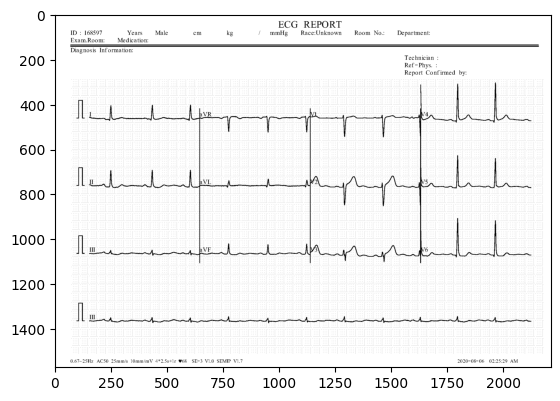

In [62]:
#  organizing imports 
import cv2          
import numpy as np     
import matplotlib.pyplot as plt
# path to input image is specified and 
# image is loaded with imread command 
image1 = cv2.imread('ECG_TEST.jpg') 
  
# cv2.cvtColor is applied over the 
# image input with applied parameters 
# to convert the image in grayscale 
img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
  
# applying Otsu thresholding 
# as an extra flag in binary  
# thresholding      
ret, thresh1 = cv2.threshold(img, 120, 225, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)      
  
# the window showing output image          
# with the corresponding thresholding          
# techniques applied to the input image     
plt.imshow(thresh1,cmap="gray") 

In [63]:
def crop_lead_I_ecg(path):
    # path to input image is specified and image is loaded with imread command 
    image1 = cv2.imread(path) 
    # cv2.cvtColor is applied over the image input with applied parametersto convert the image in grayscale 
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
    # Applying Otsu thresholding as an extra flag in binary thresholding   
    ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Now we are going to crop Patient detail from upper side of ECG Report
    crop_img = thresh1[280:1400, 90:2115]
    # Now we are going to crop single lead according to the pixels of ECG report
    crop_img = crop_img[90:200, 72:550]
    for i in range (0,crop_img.shape[0]-10):
        for j in range (0,crop_img.shape[1]-10):
            if crop_img[i][j]==0:
                count=0
                for k in range (i-5,i+5):
                    for l in range (j-5,j+5):
                        if crop_img[k][l]==0:
                            count=count+1
                if(count<5):
                    crop_img[i][j]=255
    return crop_img

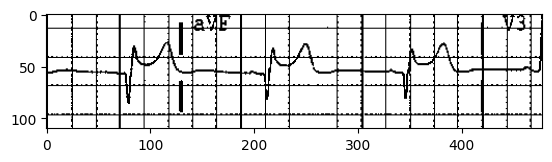

In [64]:
lead_I_img=crop_lead_I_ecg("abnormal_example.jpg")
plt.imshow(lead_I_img,cmap="gray")

In [65]:
def digitize_lead_I(img):
    pixel_from_top=[]
    pixel_from_bottom=[]
    for i in range (0,478):
        id=0
        for j in range (0,110):
            if img[j][i]==0:
                pixel_from_top.append(j)
                id=1
                break
        if id==0:
            pixel_from_top.append(pixel_from_top[i-1])
    
    for i in range (0,478):
        pixel_from_bottom.append(110-pixel_from_top[i])
    return pixel_from_bottom

In [66]:
pixels=digitize_lead_I(lead_I_img)

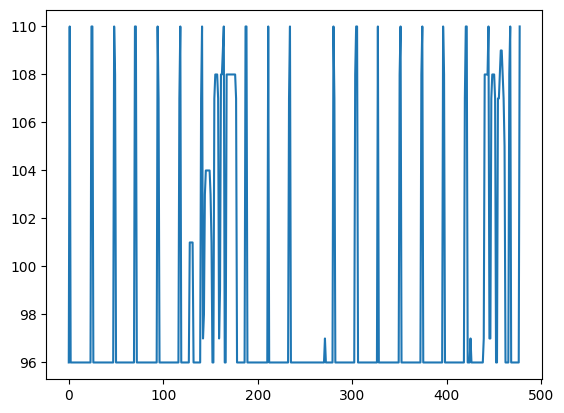

In [67]:
plt.plot(pixels)

In [68]:
# Step 1: Smooth the signal
window_size = 5
smoothed_ecg = np.convolve(pixels, np.ones(window_size)/window_size, mode='same')

In [69]:
# Step 2: Differentiate the signal
diff_ecg = np.diff(smoothed_ecg)

# Step 3: Set a threshold
threshold = 0.5 * np.max(smoothed_ecg)

In [70]:
# Step 4: Find peaks
from scipy.signal import find_peaks
r_peaks, _ = find_peaks(smoothed_ecg, height=threshold, distance=10)

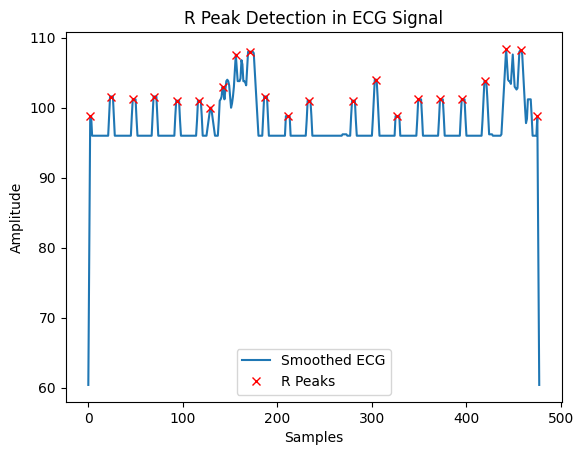

In [71]:
plt.plot(smoothed_ecg, label='Smoothed ECG')
plt.plot(r_peaks, smoothed_ecg[r_peaks], "x", label='R Peaks', color='red')
plt.title('R Peak Detection in ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [72]:
import numpy as np

# Function to calculate ST depression and slope from R-peaks
def calculate_st_depression_and_slope(ecg_signal, r_peaks, fs=1000):
    st_depressions = []
    slopes = []
    
    for r_peak in r_peaks:
        # Ensure we don't go out of bounds
        if r_peak + int(80 * fs / 1000) >= len(ecg_signal) or r_peak - int(200 * fs / 1000) < 0:
            continue  # Skip this R peak if it goes out of bounds
        
        # Segment the ECG from the J-point (after QRS complex)
        st_segment = ecg_signal[r_peak + int(60 * fs / 1000): r_peak + int(80 * fs / 1000)]  # ST segment
        baseline_segment = ecg_signal[r_peak - int(200 * fs / 1000): r_peak - int(150 * fs / 1000)]  # Baseline
        
        # Calculate ST depression: difference between ST segment and baseline
        st_depression = np.mean(st_segment) - np.mean(baseline_segment)
        st_depressions.append(st_depression)
        
        # Calculate Slope: Linear regression on ST segment (time vs amplitude)
        time = np.linspace(0, len(st_segment) / fs, len(st_segment))  # Time in seconds
        slope = np.polyfit(time, st_segment, 1)[0]  # Linear fit (slope)
        
        # Classify Slope (0: Upsloping, 1: Horizontal, 2: Downsloping)
        if slope > 0:
            slopes.append(0)  # Upsloping
        elif slope == 0:
            slopes.append(1)  # Horizontal
        else:
            slopes.append(2)  # Downsloping
    
    return st_depressions, slopes

In [73]:
# Assuming ecg_data is your ECG signal and r_peaks is the array of detected R peaks
st_depressions, slopes = calculate_st_depression_and_slope(smoothed_ecg, r_peaks, fs=1000)

# Print results
print("ST Depressions:", st_depressions)
print("Slopes:", slopes)

ST Depressions: [0.20000000000001705, 0.9200000000000017, 0.09999999999999432, -1.475999999999999, -5.423999999999964, -3.843999999999994, 3.549999999999997, 4.450000000000003]
Slopes: [2, 0, 0, 0, 2, 0, 0, 2]


In [74]:
# def calculate_st_depression_and_slope(ecg_cleaned, r_peaks, sampling_rate=1000):
#     st_depressions = []
#     slopes = []
    
#     for i in range(1, len(r_peaks) - 1):
#         # Define the ST segment (e.g., 60-80 ms after the R peak)
#         st_start = r_peaks[i] + int(0.06 * sampling_rate)  # 60 ms after R peak
#         st_end = r_peaks[i] + int(0.08 * sampling_rate)    # 80 ms after R peak

#         # Calculate ST depression
#         baseline = ecg_cleaned[r_peaks[i] - 20:r_peaks[i]].mean()  # Baseline as average 20 samples before R-peak
#         st_depression = ecg_cleaned[st_start:st_end].mean() - baseline
#         st_depressions.append(st_depression)

#         # Calculate slope and categorize it into 0, 1, 2
#         slope_value = ecg_cleaned[st_end] - ecg_cleaned[st_start]
        
#         # Categorize slope based on thresholds
#         if slope_value > 0.05:          # Adjust thresholds as needed
#             slope_category = 0          # Upsloping
#         elif -0.05 <= slope_value <= 0.05:
#             slope_category = 1          # Horizontal
#         else:
#             slope_category = 2          # Downsloping

#         slopes.append(slope_category)

#     return st_depressions, slopes

In [75]:
average_st_depression = np.mean(st_depressions)
average_slope = np.mean(slopes)

print("Average ST Depression:", average_st_depression)
print("Slope:", average_slope)

Average ST Depression: -0.190499999999993
Slope: 0.75
